<a href="https://colab.research.google.com/github/SmrithiCh/PRA3024-/blob/main/PRA3024_ML_CNN_W5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Some data-handling functions to download/import.

# from https://github.com/yandexdataschool/mlhep2018/blob/master/day2-Tue/seminar-03-keras-cnn/seminar_tf_keras.ipynb
"""I load some cifar"""

import numpy as np
from sklearn.model_selection import train_test_split
import os, sys
if sys.version_info[0] == 2:
    from urllib import urlretrieve
    import cPickle as pickle

else:
    from urllib.request import urlretrieve
    import pickle

def unpickle(file):
    fo = open(file, 'rb')
    if sys.version_info[0] == 2:
        dict = pickle.load(fo)
    else:
        dict = pickle.load(fo,encoding='latin1')

    fo.close()
    return dict




def download_cifar10(path,
                     url='https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
                     tarname='cifar-10-python.tar.gz',):
    import tarfile
    if not os.path.exists(path):
        os.mkdir(path)



    urlretrieve(url, os.path.join(path,tarname))
    tfile = tarfile.open(os.path.join(path,tarname))
    tfile.extractall(path=path)


def load_cifar10(data_path=".",channels_last=False,test_size=0.2,random_state=1337):

    test_path = os.path.join(data_path,"cifar-10-batches-py/test_batch")
    train_paths = [os.path.join(data_path,"cifar-10-batches-py/data_batch_%i"%i) for i in range(1,6)]

    if not os.path.exists(test_path) or not all(list(map(os.path.exists, train_paths))):
        print ("Dataset not found. Downloading...")
        download_cifar10(data_path)

    train_batches = list(map(unpickle,train_paths))
    test_batch = unpickle(test_path)

    X = np.concatenate([batch["data"] for batch in train_batches]).reshape([-1,3,32,32]).astype('float32')/255
    y = np.concatenate([batch["labels"] for batch in train_batches]).astype('int32')
    X_train,X_val,y_train,y_val = train_test_split(X,y,
                                                   test_size=test_size,
                                                   random_state=random_state)

    X_test = test_batch["data"].reshape([-1,3,32,32]).astype('float32')/255
    y_test = np.array(test_batch["labels"]).astype('int32')

    if channels_last:
        #convert from [batch,3,H,W] to [batch,H,W,3]
        #WARNING! Make this is only necessary for tensorflow-style dim order
        #If you use theano-style dimensions in keras config, skip this cell
        X_train = X_train.transpose([0,2,3,1])
        X_val   = X_val.transpose([0,2,3,1])
        X_test  = X_test.transpose([0,2,3,1])


    return X_train,y_train,X_val,y_val,X_test,y_test

In [2]:
import tensorflow as tf
#gpu_options = tf.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction=0.1) # restricts GPU load for multi-user nodes

import tensorflow.keras as keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)
#Says __version__ is not an attribute in tensorflow.keras even though this line of code has worked for others; made sure to reupload the file and found no changes

2.15.0


AttributeError: module 'tensorflow.keras' has no attribute '__version__'

In [3]:
# Load the data samples

x_train,y_train,x_val,y_val,x_test,y_test = load_cifar10("cifar_data",channels_last=True)

NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer",
                   "dog", "frog", "horse", "ship", "truck"]

print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)
print("Val samples:", x_val.shape, y_val.shape)

Dataset not found. Downloading...
Train samples: (40000, 32, 32, 3) (40000,)
Test samples: (10000, 32, 32, 3) (10000,)
Val samples: (10000, 32, 32, 3) (10000,)


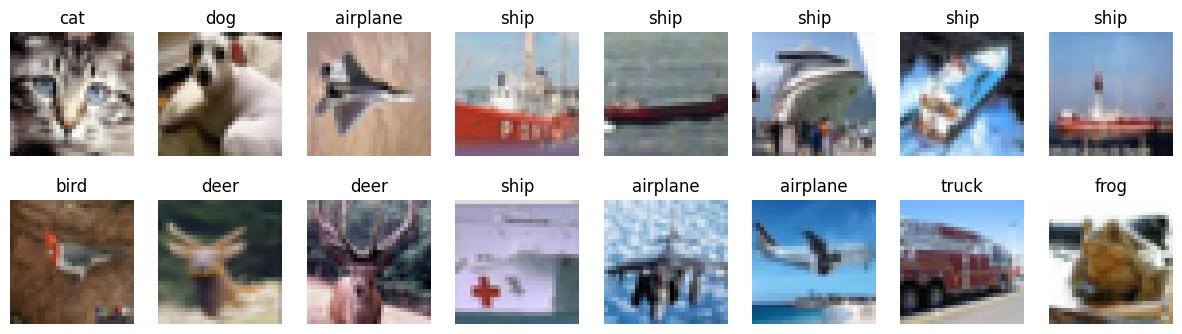

In [4]:
# show some random images from train, and their labels

cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index]])
plt.show()

In [5]:
# normalize inputs
# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
# x_train = x_train.astype(np.float64) - 0.5

y_train = keras.utils.to_categorical(y_train, num_classes=10)

y_val = keras.utils.to_categorical(y_val, num_classes=10)

y_test = keras.utils.to_categorical(y_test, num_classes=10)

In [6]:
# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.layers.advanced_activations import LeakyReLU

ModuleNotFoundError: No module named 'keras.layers.advanced_activations'

## I will be investigating the difference between ReLu, LeakyReLu and ParametricReLu by making 3 CNN models and comparing their accuracies over a set ammount of training time

In [7]:
from keras.layers import BatchNormalization


A first attempt for the CNN architecture was made to look similar to that of [Khanday et al.](https://ijai.iaescore.com/index.php/IJAI/article/download/20718/13238#:~:text=Filter%20sizes%20come%20in%20various,filter%20sizes%20on%20image%20classification.) using the following code. However, this did not give good results (accuracy<15% and loss>7), and did not improve per epoch. This is why a different, more simple method was adopted.

### Code that didn't work:



In [8]:
#    #CNN's architecture is identical to Khanday et al. $$
#     #InputLayer has been replaced with another Conv2D layer with input shape parameters defined $$
#    model.add(Conv2D(32, kernel_size = (3,3), activation="ReLU", input_shape=(32, 32, 3))
#    model.add(Conv2D(32, kernel_size = (3,3), activation="ReLU"))
#    model.add(Conv2D(32, kernel_size = (3,3), activation="ReLU"))
#    # stabilise CNN: batch normalisation rescales and recenters data inputs (https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/)
#    model.add(BatchNormalization())
#    # output activation function arbitrarily set to softmax
#    model.add(Activation("softmax"))
#    # pooling after Conv2D layers using MaxPooling2D to retrieve the maximum value in each patch
#    model.add(MaxPooling2D(2,2))
#    model.add(Dropout(0.25))
#    model.add(Flatten())
#    model.add(Dense(256))
#    model.add(BatchNormalization())
#    model.add(Activation("softmax"))
#    model.add(Dropout(0.25))
#    model.add(Dense(10))

#    return model

In [9]:
# Convolutional Neural Network 1: Activation Function = ReLU
def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """

    model = Sequential()

    # Kernel size is set to 3x3 which should give the largest accuracy rate for this dataset (Khanday et al., 2021)
    # Activation function set to ReLu
    # padding="same" newly included to ensure input and output have same number of spatial dimensions
    model.add(Conv2D(32, kernel_size = (3,3), activation="ReLU", padding="Same"))
    model.add(Conv2D(32, kernel_size = (3,3), activation="ReLU", padding="Same"))
    # stabilise CNN: batch normalisation rescales and recenters data inputs (https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/)
    model.add(BatchNormalization())
    # pooling after Conv2D layers using MaxPooling2D to retrieve the maximum value in each patch
    model.add(MaxPooling2D(2,2))
    # another batch norm after pooling
    model.add(BatchNormalization())

    # repeat CNN layers, but double number of filters for each run
    model.add(Conv2D(64, kernel_size = (3,3), activation="ReLU", padding="Same"))
    model.add(Conv2D(64, kernel_size = (3,3), activation="ReLU", padding="Same"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization())

    model.add(Conv2D(128, kernel_size = (3,3), activation="ReLU", padding="Same"))
    model.add(Conv2D(128, kernel_size = (3,3), activation="ReLU", padding="Same"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization())

    model.add(Conv2D(256, kernel_size = (3,3), activation="ReLU", padding="Same"))
    model.add(Conv2D(256, kernel_size = (3,3), activation="ReLU", padding="Same"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization())

    # flatten output into an array
    model.add(Flatten())

    # connect every neural node to every other using dense. Set value to 10 as 10 classes are being identified
    model.add(Dense(10))

    # common dropout values fall between 0.2 - 0.5, I will be using the smallest value in order to keep more of the neurons
    model.add(Dropout(0.2))

    # output activation function arbitrarily set to softmax; it is hoped that this won't influence the experiment much if kept consistent in the LeakyReLU and PReLU CNNs
    model.add(Activation("softmax"))

    return model

This neural network architecture is similar to [Simone's](https://github.com/simpapa/PRA3024/blob/main/ML_cifar_CNN_exercise.ipynb), where I have borrowed the systematic dual layers per filter size approach from. Moreover, I have also been inspired by Simone to use progressive feature map enlargement (doubling filter size per 'run') as it allows my CNN to recognise niche/small features in the larger filters as well as general features in the smaller filters, making it more accurate.

In [10]:
INIT_LR = 5e-3  # initial learning rate
BATCH_SIZE = 32
EPOCHS = 10


K.clear_session()  # clear default graph
# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)
model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.Adamax(lr=INIT_LR),  # for SGD.
    metrics=['accuracy']  # report accuracy during training
)

# fit model
model.fit(
    x_train, y_train,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    shuffle=True,
)

# save weights to file to avoid re-training
model.save_weights("weights.h5")

Epoch 1/10
1250/1250 [==============================] - 21s 10ms/step - loss: 1.6394 - accuracy: 0.4286 - val_loss: 1.3093 - val_accuracy: 0.5388
Epoch 2/10
1250/1250 [==============================] - 11s 9ms/step - loss: 1.2258 - accuracy: 0.5659 - val_loss: 1.0513 - val_accuracy: 0.6268
Epoch 3/10
1250/1250 [==============================] - 11s 8ms/step - loss: 0.9802 - accuracy: 0.6451 - val_loss: 0.8062 - val_accuracy: 0.7158
Epoch 4/10
1250/1250 [==============================] - 10s 8ms/step - loss: 0.8229 - accuracy: 0.6972 - val_loss: 0.7672 - val_accuracy: 0.7317
Epoch 5/10
1250/1250 [==============================] - 10s 8ms/step - loss: 0.6866 - accuracy: 0.7393 - val_loss: 0.7260 - val_accuracy: 0.7579
Epoch 6/10
1250/1250 [==============================] - 11s 8ms/step - loss: 0.5672 - accuracy: 0.7765 - val_loss: 0.7314 - val_accuracy: 0.7681
Epoch 7/10
1250/1250 [==============================] - 11s 9ms/step - loss: 0.4730 - accuracy: 0.8077 - val_loss: 0.7581 - val_a

Run attempt 1: (forgot to save to github)

Accuracy was as high as 88% (epochs 19 and 20) and validation accuracy was met with 78%. The CNN also hit 80% accuracy by the 8th epoch, showing that it is fairly effective.

Run Attempt 2 (Colab GPU was timed out, so only 10 epochs were run to keep consistent with leakyremu and premu):



We can now use the same template to identify whether and how different Conv2D activation functions would affect this CNN architecture.

In [11]:
# load weights from file (can call without model.fit)
model.load_weights("weights.h5")

# LeakyReLU

In [12]:
# Convolutional Neural Network 2: Activation Function = LeakyReLU
def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """

    model_leaky = Sequential()

    model_leaky.add(Conv2D(32, kernel_size = (3,3), activation="LeakyReLU", padding="Same"))
    model_leaky.add(Conv2D(32, kernel_size = (3,3), activation="LeakyReLU", padding="Same"))
    model_leaky.add(BatchNormalization())
    model_leaky.add(MaxPooling2D(2,2))
    model_leaky.add(BatchNormalization())

    model_leaky.add(Conv2D(64, kernel_size = (3,3), activation="LeakyReLU", padding="Same"))
    model_leaky.add(Conv2D(64, kernel_size = (3,3), activation="LeakyReLU", padding="Same"))
    model_leaky.add(BatchNormalization())
    model_leaky.add(MaxPooling2D(2,2))
    model_leaky.add(BatchNormalization())

    model_leaky.add(Conv2D(128, kernel_size = (3,3), activation="LeakyReLU", padding="Same"))
    model_leaky.add(Conv2D(128, kernel_size = (3,3), activation="LeakyReLU", padding="Same"))
    model_leaky.add(BatchNormalization())
    model_leaky.add(MaxPooling2D(2,2))
    model_leaky.add(BatchNormalization())

    model_leaky.add(Conv2D(256, kernel_size = (3,3), activation="LeakyReLU", padding="Same"))
    model_leaky.add(Conv2D(256, kernel_size = (3,3), activation="LeakyReLU", padding="Same"))
    model_leaky.add(BatchNormalization())
    model_leaky.add(MaxPooling2D(2,2))
    model_leaky.add(BatchNormalization())

    model_leaky.add(Flatten())
    model_leaky.add(Dense(10))
    model_leaky.add(Dropout(0.2))
    model_leaky.add(Activation("softmax"))

    return model_leaky

In [13]:
INIT_LR = 5e-3  # initial learning rate
BATCH_SIZE = 32
EPOCHS = 10


K.clear_session()  # clear default graph
# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)
model_leaky = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model_leaky.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.Adamax(lr=INIT_LR),  # for SGD.
    metrics=['accuracy']  # report accuracy during training
)

# fit model
model_leaky.fit(
    x_train, y_train,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    shuffle=True,
)

# save weights to file to avoid re-training
model_leaky.save_weights("weights.h5")

Epoch 1/10
1250/1250 [==============================] - 18s 10ms/step - loss: 1.5406 - accuracy: 0.4700 - val_loss: 1.1609 - val_accuracy: 0.5926
Epoch 2/10
1250/1250 [==============================] - 11s 8ms/step - loss: 1.1410 - accuracy: 0.5944 - val_loss: 0.8450 - val_accuracy: 0.7149
Epoch 3/10
1250/1250 [==============================] - 11s 8ms/step - loss: 0.9282 - accuracy: 0.6641 - val_loss: 0.8587 - val_accuracy: 0.6986
Epoch 4/10
1250/1250 [==============================] - 11s 9ms/step - loss: 0.7812 - accuracy: 0.7106 - val_loss: 0.7639 - val_accuracy: 0.7443
Epoch 5/10
1250/1250 [==============================] - 11s 9ms/step - loss: 0.6644 - accuracy: 0.7478 - val_loss: 0.6924 - val_accuracy: 0.7670
Epoch 6/10
1250/1250 [==============================] - 11s 9ms/step - loss: 0.5603 - accuracy: 0.7772 - val_loss: 0.6833 - val_accuracy: 0.7757
Epoch 7/10
1250/1250 [==============================] - 11s 9ms/step - loss: 0.4734 - accuracy: 0.8052 - val_loss: 0.7144 - val_a

In [14]:
model_leaky.load_weights("weights.h5")

# Parametric ReLU

In [15]:
# Convolutional Neural Network 3: Activation Function = PReLU
def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """

    model_para = Sequential()

    model_para.add(Conv2D(32, kernel_size = (3,3), activation="PReLU", padding="Same"))
    model_para.add(Conv2D(32, kernel_size = (3,3), activation="LeakyReLU", padding="Same"))
    model_para.add(BatchNormalization())
    model_para.add(MaxPooling2D(2,2))
    model_para.add(BatchNormalization())

    model_para.add(Conv2D(64, kernel_size = (3,3), activation="PReLU", padding="Same"))
    model_para.add(Conv2D(64, kernel_size = (3,3), activation="LeakyReLU", padding="Same"))
    model_para.add(BatchNormalization())
    model_para.add(MaxPooling2D(2,2))
    model_para.add(BatchNormalization())

    model_para.add(Conv2D(128, kernel_size = (3,3), activation="PReLU", padding="Same"))
    model_para.add(Conv2D(128, kernel_size = (3,3), activation="PReLU", padding="Same"))
    model_para.add(BatchNormalization())
    model_para.add(MaxPooling2D(2,2))
    model_para.add(BatchNormalization())

    model_para.add(Conv2D(256, kernel_size = (3,3), activation="PReLU", padding="Same"))
    model_para.add(Conv2D(256, kernel_size = (3,3), activation="PReLU", padding="Same"))
    model_para.add(BatchNormalization())
    model_para.add(MaxPooling2D(2,2))
    model_para.add(BatchNormalization())

    model_para.add(Flatten())
    model_para.add(Dense(10))
    model_para.add(Dropout(0.2))
    model_para.add(Activation("softmax"))

    return model_para

In [16]:
INIT_LR = 5e-3  # initial learning rate
BATCH_SIZE = 32
EPOCHS = 10


K.clear_session()  # clear default graph
# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)
model_para = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model_para.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.Adamax(lr=INIT_LR),  # for SGD.
    metrics=['accuracy']  # report accuracy during training
)

# fit model
model_para.fit(
    x_train, y_train,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    shuffle=True,
)

# save weights to file to avoid re-training
model_para.save_weights("weights.h5")

Epoch 1/10
1250/1250 [==============================] - 21s 12ms/step - loss: 1.6012 - accuracy: 0.4435 - val_loss: 1.3798 - val_accuracy: 0.5182
Epoch 2/10
1250/1250 [==============================] - 14s 11ms/step - loss: 1.2038 - accuracy: 0.5745 - val_loss: 1.1181 - val_accuracy: 0.6047
Epoch 3/10
1250/1250 [==============================] - 14s 11ms/step - loss: 0.9614 - accuracy: 0.6525 - val_loss: 0.8241 - val_accuracy: 0.7176
Epoch 4/10
1250/1250 [==============================] - 14s 11ms/step - loss: 0.7976 - accuracy: 0.7060 - val_loss: 0.7665 - val_accuracy: 0.7405
Epoch 5/10
1250/1250 [==============================] - 14s 11ms/step - loss: 0.6520 - accuracy: 0.7509 - val_loss: 0.7108 - val_accuracy: 0.7634
Epoch 6/10
1250/1250 [==============================] - 13s 11ms/step - loss: 0.5401 - accuracy: 0.7858 - val_loss: 0.7167 - val_accuracy: 0.7774
Epoch 7/10
1250/1250 [==============================] - 14s 11ms/step - loss: 0.4370 - accuracy: 0.8169 - val_loss: 0.7505 -

In [17]:
model_para.load_weights("weights.h5")

313/313 [==============================] - 1s 3ms/step


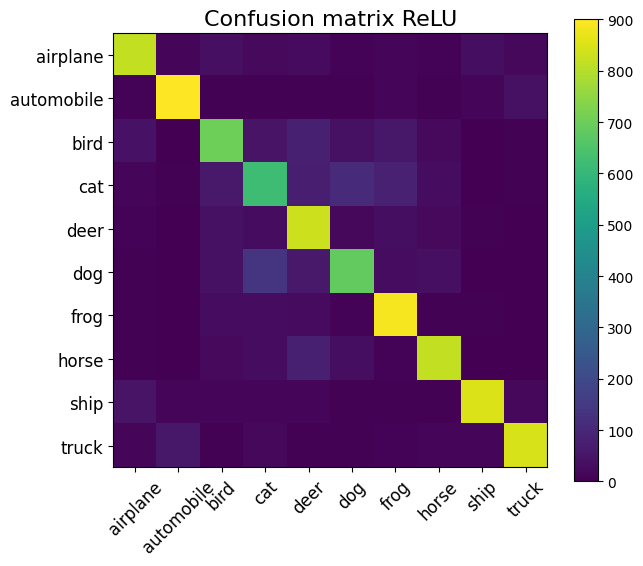

Test accuracy: 0.7961


In [44]:
# make test predictions: CNN1 ReLU
y_pred_test = model.predict(x_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)
y_test_index = [list(onehot).index(1) for onehot in y_test]


# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix ReLU', fontsize=16)
plt.imshow(confusion_matrix(y_test_index, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test_index, y_pred_test_classes))

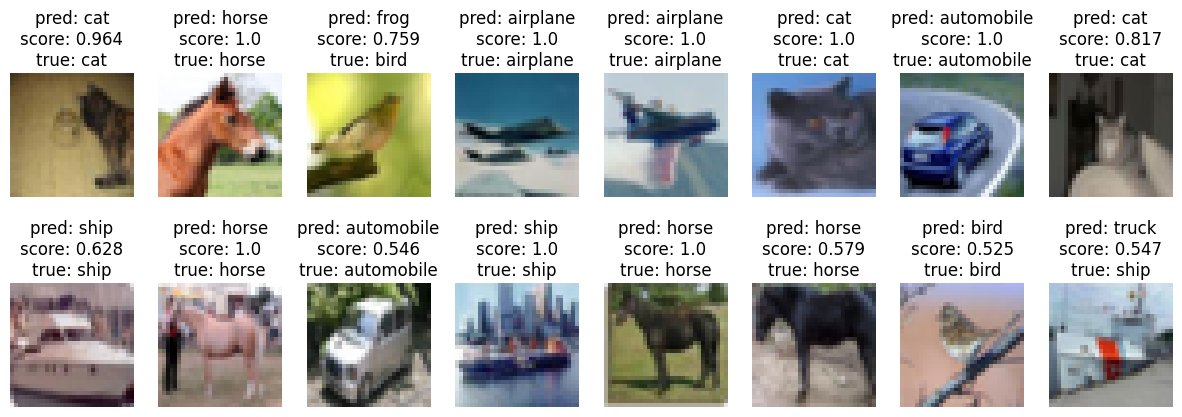

In [45]:
# inspect preditions
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test_index[random_index]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()

the ReMU model is acting like a usual CNN that perhaps needs a few more epochs to be fully trained. It shows a largely consistent confusion matrix, but it is clear cats, birds and dogs are more confused with than other objects.

313/313 [==============================] - 1s 3ms/step


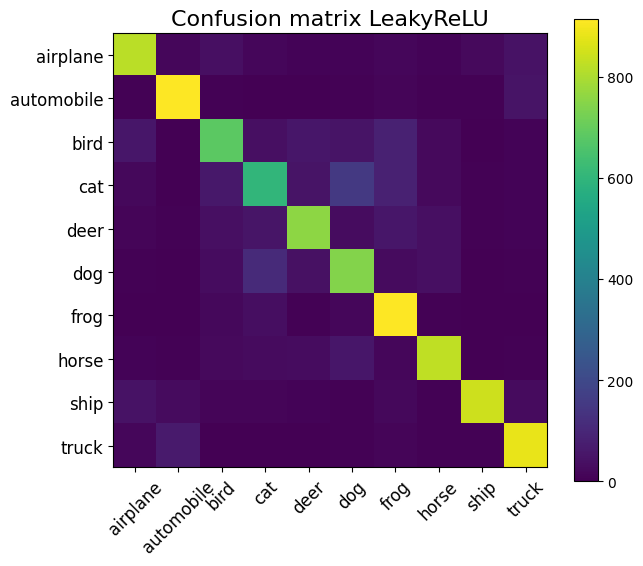

Test accuracy: 0.7975


In [42]:
# make test predictions: CNN2 LeakyReLU
y_pred_test_l = model_leaky.predict(x_test)
y_pred_test_classes_l = np.argmax(y_pred_test_l, axis=1)
y_pred_test_max_probas_l = np.max(y_pred_test_l, axis=1)
y_test_index_l = [list(onehot).index(1) for onehot in y_test]


# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix LeakyReLU', fontsize=16)
plt.imshow(confusion_matrix(y_test_index_l, y_pred_test_classes_l))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test_index_l, y_pred_test_classes_l))

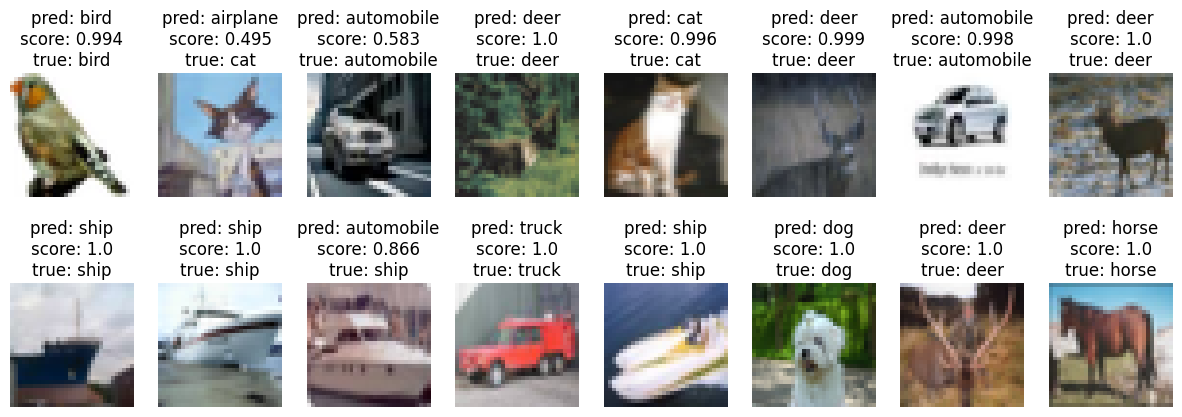

In [43]:
# inspect preditions CNN2 LeakyReLU
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label_l = cifar10_classes[y_pred_test_classes_l[random_index]]
        pred_proba_l = y_pred_test_max_probas_l[random_index]
        true_label_l = cifar10_classes[y_test_index_l[random_index]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label_l, pred_proba_l, true_label_l
        ))
plt.show()

While good in general, the LeakyReMU model seems a little undertrained, which can be seen in the 0.583 score for automobile, which it guessed correctly, and the overshot score of 0.866 for the ship it guessed as an Automobile. Furthermore, cats seem to still be difficult to identify.

313/313 [==============================] - 1s 4ms/step


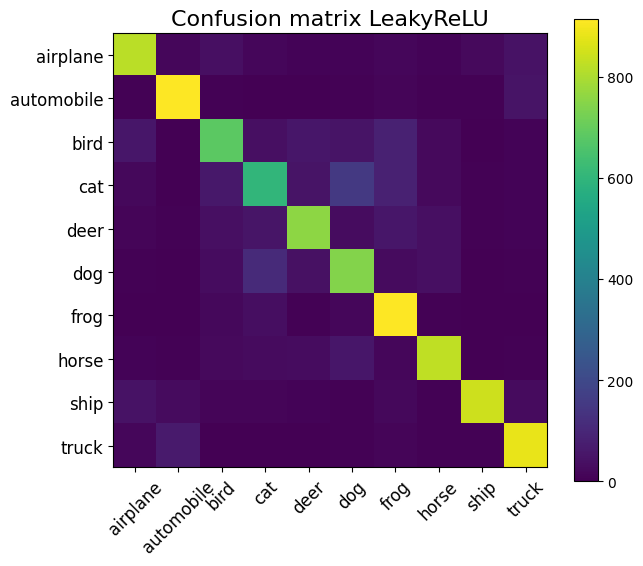

Test accuracy: 0.7975


In [40]:
# make test predictions: CNN3 PReLU
y_pred_test_p = model_leaky.predict(x_test)
y_pred_test_classes_p = np.argmax(y_pred_test_p, axis=1)
y_pred_test_max_probas_p = np.max(y_pred_test_p, axis=1)
y_test_index_p = [list(onehot).index(1) for onehot in y_test]


# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix LeakyReLU', fontsize=16)
plt.imshow(confusion_matrix(y_test_index_p, y_pred_test_classes_p))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test_index_p, y_pred_test_classes_p))

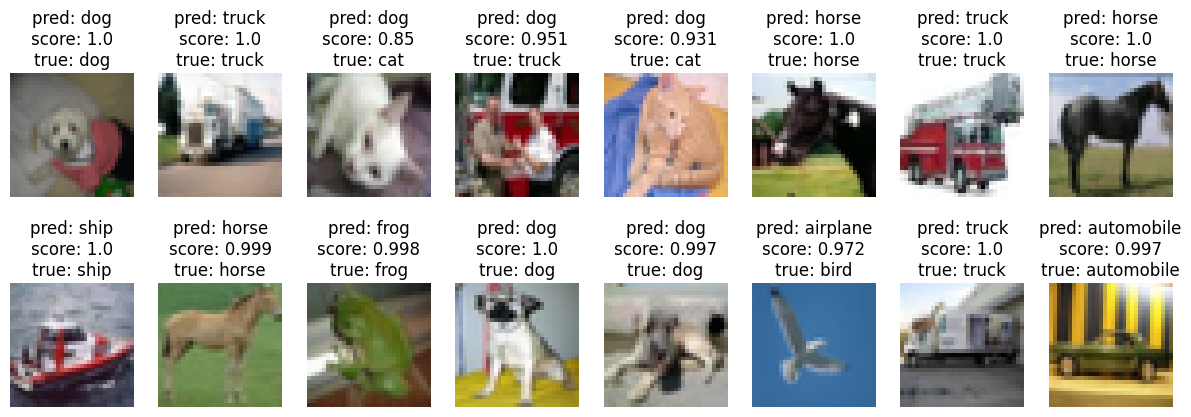

In [41]:
# inspect preditions CNN3 PReLU
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label_p = cifar10_classes[y_pred_test_classes_p[random_index]]
        pred_proba_p = y_pred_test_max_probas_p[random_index]
        true_label_p = cifar10_classes[y_test_index_p[random_index]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label_p, pred_proba_p, true_label_p
        ))
plt.show()

While the PReLU model seems more sure of itself in general with all scores at or above 0.85, it seems to still be inaccurate 4 out of 16 times. It is too sure of itself. While I would attempt to fix this by increasing the dropout rate, this action would make the comparison between the 3 models invalid. Moreover, cats seem to be a common enemy for all 3 models.

In [34]:
# Freshly training the models and plotting model accuracies against each other
history1 = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_val, y_val), verbose=1)
history2 = model_leaky.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_val, y_val), verbose=1)
history3 = model_para.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_val, y_val), verbose=1)

Epoch 1/10
1250/1250 [==============================] - 12s 9ms/step - loss: 0.2448 - accuracy: 0.8733 - val_loss: 1.0538 - val_accuracy: 0.7963
Epoch 2/10
1250/1250 [==============================] - 15s 12ms/step - loss: 0.2277 - accuracy: 0.8769 - val_loss: 1.1107 - val_accuracy: 0.7891
Epoch 3/10
1250/1250 [==============================] - 19s 15ms/step - loss: 0.2143 - accuracy: 0.8834 - val_loss: 1.1079 - val_accuracy: 0.7939
Epoch 4/10
1250/1250 [==============================] - 20s 16ms/step - loss: 0.2136 - accuracy: 0.8827 - val_loss: 1.1481 - val_accuracy: 0.7952
Epoch 5/10
1250/1250 [==============================] - 15s 12ms/step - loss: 0.2144 - accuracy: 0.8829 - val_loss: 1.2207 - val_accuracy: 0.7885
Epoch 6/10
1250/1250 [==============================] - 11s 9ms/step - loss: 0.2140 - accuracy: 0.8831 - val_loss: 1.1914 - val_accuracy: 0.7893
Epoch 7/10
1250/1250 [==============================] - 11s 9ms/step - loss: 0.2136 - accuracy: 0.8824 - val_loss: 1.1760 - va

In [38]:
score1 = model.evaluate(x_test, y_test, verbose=0)
score2 = model_leaky.evaluate(x_test, y_test, verbose=0)
score3 = model_para.evaluate(x_test, y_test, verbose=0)

print('Model ReLU Test Accuracy:', score1[1])
print('Model LeakyReLU Test Accuracy:', score2[1])
print('Model PReLU Test Accuracy:', score3[1])

Model ReLU Test Accuracy: 0.7961000204086304
Model LeakyReLU Test Accuracy: 0.7975000143051147
Model PReLU Test Accuracy: 0.7982000112533569


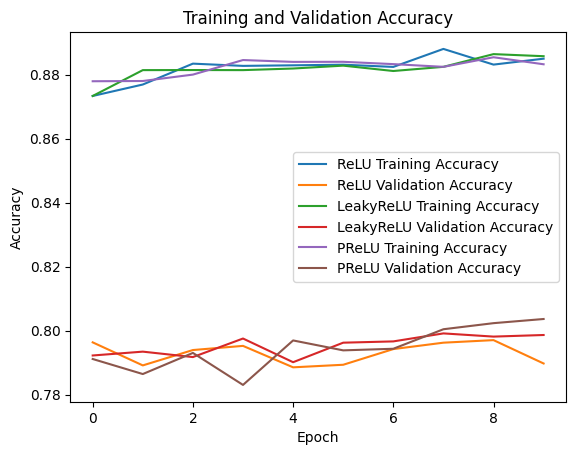

In [39]:
plt.plot(history1.history['accuracy'], label='ReLU Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='ReLU Validation Accuracy')
plt.plot(history2.history['accuracy'], label='LeakyReLU Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='LeakyReLU Validation Accuracy')
plt.plot(history3.history['accuracy'], label='PReLU Training Accuracy')
plt.plot(history3.history['val_accuracy'], label='PReLU Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

As expected, all 3 CNNs did a better job, and were more consistent with training data than with validation data. While above 80% was not achieved by any of the 3 models, all 3 got to 79% at least, with the PReLU model getting closest with 79.82%.

While it can be concluded that the PReLU model might be the most effective in this CNN architecture, it is hard to say with only 10 epochs. Furthermore, my PReLU model has problems with overshooting it's surity score during predictions, and an anomoly in epoch 3 for validation efficiencies makes it more difficult to see a general trend.  

Due to overheating my laptop, I am afraid to attempt more epochs per model, however, and will conclude this study as follows:
A general effective model using Conv2D activation functions cannot be chosen as they don't seem to vary too greatly. oOr this reason, any of the 3 functions can be used to form a CNN for this dataset, and significant improvements in accuracy are more likely to be made by improving the CNN architecture in itself rather than the activation function, as seen early on in this project.


If presented with more time, it might be useful to see how a CNN with all 3 conv2d activation functions wold act, and a study of whether a particular order is more effective than the others could be done.